# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 100%; text-align: center; border-radius : 15px 15px;"> Are Sequels Better Than the Original? </p>

<p style = "text-align: center; font-family : newtimeroman; font-size: 120%;">
<strong> Justin Cheigh and Daisuke Yamada <br>
<strong> DIS Copenhagen, Spring 2023 <br> 
<strong> Computational Analysis of Big Data: Final Project </p>

In this project, we seek to answer the question of whether sequels are better than the original. To this end, we implement and train a **bidirectional-LSTM** using Keras and TensorFlow and perform **Sentiment Analysis** on reviews of pariticular movie series to investigate what the trend of each series looks like as it goes further. Our training dataset comes from <a href="https://www.kaggle.com/datasets/shivam2503/diamonds"> kaggle,</a> and it contains 50,000 movie reviews (as strings) labeled "positive" or "negative". We also scrape movies reviews of the series from IMDb using Python's **selenium** libraray.

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Table of Contents</p> 

|No  | Contents |
|:---| :---     |
|1   | Data Preparation Part 1 |
|2   | Data Preparation Part 2 |
|3   | Implement/Train Model   |
|4   | Model Evaluation        |  
|5   | Collect Sentiment Results by Prediction |         
|6   | Examine Sentiments Part 1 |   
|7   | Examine Sentiments Part 2 |
|8   | Summary and Future Work |

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Data Preparation</p> 

### 1. Download stentiment analysis datasets 
We get our training dataset from <a href="https://www.kaggle.com/datasets/shivam2503/diamonds"> kaggle,</a> and store them under */train_data* directory as CSV files.

### 2. Download IMDb datasets 

In this section, we scrape reviews on the four different movie series, **Harry Potter**, **Star Wars**, **Kung Fu Panda**, and **Cars**, from IMBd using *Selenium* Libraray. 

#### 2.1 Libraraies

In [2]:
import numpy as np
import pandas as pd
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.support import ui
import time
from tqdm import tqdm
import warnings
import os.path
warnings.filterwarnings("ignore")

#### 2.2 Get URLs for the movies

In [3]:
# Harry Potter Series
hp0_url = 'https://www.imdb.com/title/tt0241527/reviews?ref_=tt_urv'
hp1_url = 'https://www.imdb.com/title/tt0295297/reviews?ref_=tt_urv'
hp2_url = 'https://www.imdb.com/title/tt0304141/reviews?ref_=tt_urv'
hp3_url = 'https://www.imdb.com/title/tt0330373/reviews?ref_=tt_urv'
hp4_url = 'https://www.imdb.com/title/tt0373889/reviews?ref_=tt_urv'
hp5_url = 'https://www.imdb.com/title/tt0417741/reviews?ref_=tt_urv'
hp6_url = 'https://www.imdb.com/title/tt0926084/reviews?ref_=tt_urv'
hp7_url = 'https://www.imdb.com/title/tt1201607/reviews?ref_=tt_urv'

# Star Wars
sw0_url = 'https://www.imdb.com/title/tt0120915/reviews?ref_=tt_urv'
sw1_url = 'https://www.imdb.com/title/tt0121765/reviews?ref_=tt_urv'
sw2_url = 'https://www.imdb.com/title/tt0121766/reviews?ref_=tt_urv'
sw3_url = 'https://www.imdb.com/title/tt0076759/reviews?ref_=tt_urv'
sw4_url = 'https://www.imdb.com/title/tt0080684/reviews?ref_=tt_urv'
sw5_url = 'https://www.imdb.com/title/tt0086190/reviews?ref_=tt_urv'
sw6_url = 'https://www.imdb.com/title/tt2488496/reviews?ref_=tt_urv'
sw7_url = 'https://www.imdb.com/title/tt2527336/reviews?ref_=tt_urv'
sw8_url = 'https://www.imdb.com/title/tt2527338/reviews?ref_=tt_urv'

# Kung Fu Panda
kp0_url = 'https://www.imdb.com/title/tt0441773/reviews?ref_=tt_urv'
kp1_url = 'https://www.imdb.com/title/tt1302011/reviews?ref_=tt_urv'
kp2_url = 'https://www.imdb.com/title/tt2267968/reviews?ref_=tt_urv'

# Cars
cars0_url = 'https://www.imdb.com/title/tt0317219/reviews?ref_=tt_urv'
cars1_url = 'https://www.imdb.com/title/tt1216475/reviews?ref_=tt_urv'
cars2_url = 'https://www.imdb.com/title/tt3606752/reviews?ref_=tt_urv'

# aggregate urls
url_dict = {
    'harry_potter': [hp0_url, hp1_url, hp2_url, hp3_url, hp4_url, hp5_url, hp6_url, hp7_url],
    'star_wars': [sw0_url, sw1_url, sw2_url, sw3_url, sw4_url, sw5_url, sw6_url, sw7_url, sw8_url],
    'kung_fu_panda': [kp0_url, kp1_url, kp2_url],
    'cars': [cars0_url, cars1_url, cars2_url]
}

#### 2.3 Extract and save reviews
We use the urls above to extract the reviews and save them as individual CSV files under each directory.

In [22]:
# return reviews, titles, and rating as a dataframe 
def get_df(url):
    # webdriver file
    PATH = r"C:\chromedriver.exe"
    driver = webdriver.Chrome(PATH)
    driver.get(url)

    # create waiter
    wait = ui.WebDriverWait(driver, 10)

    # load pages
    sel = Selector(text = driver.page_source)
    review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
    more_review_pages = int(int(review_counts)/25)
    print(f'there are {review_counts} reviews')
    for _ in tqdm(range(more_review_pages)):
        try:
            driver.find_element(By.ID, 'load-more-trigger').click() 
            time.sleep(2.0)
        except:
            pass

    # get lists
    rating_list = []
    review_title_list = []
    review_list = []
    error_url_list = []
    error_msg_list = []
    reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

    # cnt = 0
    for d in tqdm(reviews):
        try:
            sel2 = Selector(text = d.get_attribute('innerHTML'))
            # review rating
            try:
                rating = sel2.css('.rating-other-user-rating span::text').extract_first()
            except:
                rating = np.NaN
            # review text
            try:
                review = sel2.css('.text.show-more__control::text').extract_first()
            except:
                review = np.NaN

            # review title
            try:
                review_title = sel2.css('a.title::text').extract_first()
            except:
                review_title = np.NaN

            # append info
            if rating is None:
                rating = np.NaN
            if review_title is None:
                review_title = np.NaN
            if review is None:
                review = np.NaN

            rating_list.append(rating)
            review_title_list.append(review_title[1:-1])
            review_list.append(review.replace('\n', '<br /><br />'))
            if not len(rating_list) == len(review_list) == len(review_title_list):
                review_list.append(' ')
            # cnt += 1

        except Exception as e:
            error_url_list.append(url)
            error_msg_list.append(e)

    # print(len(rating_list), len(review_title_list), len(review_list), cnt)

    # convert to df
    review_df = pd.DataFrame({
        'Rating': rating_list,
        'Review_Title': review_title_list,
        'Review': review_list
    })
    return review_df

# convert df to csv
def save_csv(df, filepath):
    df.to_csv(filepath)

# scrape
for series, urls in url_dict.items():
    print(f'Processing {series}...')
    index = 0
    for url in urls:
        filepath = f'./reviews/original/{series}/{index}.csv'
        try:
            f = open(filepath)
            f.close()
            print(f'{filepath} already exists')
        except FileNotFoundError:
            print(f'working on {filepath}...')
            review_df = get_df(url=url)
            save_csv(df=review_df, filepath=filepath)
        index += 1

Processing harry_potter...
./reviews/original/harry_potter/0.csv already exists
./reviews/original/harry_potter/1.csv already exists
./reviews/original/harry_potter/2.csv already exists
./reviews/original/harry_potter/3.csv already exists
./reviews/original/harry_potter/4.csv already exists
./reviews/original/harry_potter/5.csv already exists
./reviews/original/harry_potter/6.csv already exists
./reviews/original/harry_potter/7.csv already exists
Processing star_wars...
./reviews/original/star_wars/0.csv already exists
./reviews/original/star_wars/1.csv already exists
./reviews/original/star_wars/2.csv already exists
./reviews/original/star_wars/3.csv already exists
./reviews/original/star_wars/4.csv already exists
./reviews/original/star_wars/5.csv already exists
./reviews/original/star_wars/6.csv already exists
./reviews/original/star_wars/7.csv already exists
./reviews/original/star_wars/8.csv already exists
Processing kung_fu_panda...
./reviews/original/kung_fu_panda/0.csv already 

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Build Bidirectional LSTM</p> 

In this section, we aim to implement a bidirectional LSTM from scratch using Keras and TensorFlow. We use pre-trained **GloVe** word embedding (saved under *./glove*) to define an embedding layer and incorporate it into our model to achieve higher accuracy. 

### 3. Implemenet and Train Bidirectional LSTM

#### 3.1 Libraraies

In [1]:
# python files
import data

# data analysis libraries 
import numpy as np
import pandas as pd
import pickle

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# tensorflow/keras 
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Embedding
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# warning and other config
import warnings
warnings.filterwarnings('ignore')
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2023-04-26 18:53:48.766761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daisukeyamada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 3.2 GPU seeting and hyper-parameters

In [2]:
# device setting
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
device = cpu_device

# hyper parameters
batch_size = 100
epochs = 5

#### 3.3 Preprocess train, test, and validation data

In [3]:
with tf.device(device):
    # read csv files
    dataset = pd.concat([pd.read_csv("./train_data/train.csv"), pd.read_csv("./train_data/test.csv")], ignore_index=True)

    # parse texts
    text = data.parse_texts(dataset['text'])

    # mapping: {positive, negative} -> {1, 0}
    label_encoder = LabelEncoder()
    dataset["sentiment"] = label_encoder.fit_transform(dataset["sentiment"])

    # split data into training, test, and validation
    x_train, x_test, y_train, y_test = train_test_split(text, dataset['sentiment'], train_size=0.8, random_state=101)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.7, random_state=101)
    print(f'Found {len(x_train)} train data')
    print(f'Found {len(x_test)} test data')
    print(f'Found {len(x_val)} validation data')

    # tokenize datasets
    num_words = max([len(t.split()) for t in text], key=int)
    tokenizer = Tokenizer(num_words = num_words, oov_token="<OOV>") 
    tokenizer.fit_on_texts(text)
    word_index = tokenizer.word_index
    print(f'Found {len(word_index)} words')

    # save tokenizer
    with open('./tokenizer/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # process each dataset with tokenizer
    seqlen = 200
    process = lambda data, seqlen: pad_sequences(tokenizer.texts_to_sequences(data), maxlen=seqlen, padding="post", truncating="post")
    x_train, x_test, x_val = process(x_train, seqlen), process(x_test, seqlen), process(x_val, seqlen)

Found 40000 train data
Found 7000 test data
Found 3000 validation data
Found 99274 words


We create data.py that does the same thing as above so that we can access the code outside this notebook.

#### 3.4 Define embedding layer with GloVe Embeddings

In [120]:
with tf.device(device):
    # load GloVe embeddings
    embedding = {}
    with open('./glove/glove.6B.200d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vec = np.asarray(values[1:], dtype='float32')
            embedding[word] = vec

    print(f'Found {len(embedding)} words in embedding space')

    # create embedding matrix
    embedding_matrix = np.zeros((len(word_index)+1, seqlen))

    for word, i in word_index.items():
        if word in embedding:
            vec = embedding[word]
            embedding_matrix[i] = vec
    print(f'Found matrix of shape {embedding_matrix.shape}')

    # define pre-trained embedding layer
    pre_emb = Embedding(
        input_dim=len(word_index)+1, 
        output_dim=seqlen, 
        weights=[embedding_matrix], 
        input_length=seqlen, 
        trainable=True
    )

    # define trainable embedding layer 
    emb = Embedding(
        input_dim=len(word_index)+1, 
        output_dim=128, 
        input_length=seqlen
    )

Found 400000 words in embedding space
Found matrix of shape (99275, 200)


#### 3.5 Define and compile Bidirectional LSTM

In [121]:
with tf.device(device):
    # define bidirectional LSTM
    model = Sequential([
        pre_emb,
        Bidirectional(LSTM(128, return_sequences=True)), 
        Dropout(0.2),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    # compile
    model.compile(
        loss=BinaryCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=['accuracy']
    )

#### 3.6 Train and save Bidirectional LSTM

In [122]:
with tf.device(device):
    # fit 
    model.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val, y_val), 
        validation_split=0.2,
    )

    # save
    model.save('./saved_models/lstm')

Epoch 1/5
400/400 [==============================] - 395s 980ms/step - loss: 0.4919 - accuracy: 0.7625 - val_loss: 0.3666 - val_accuracy: 0.8383
Epoch 2/5
400/400 [==============================] - 391s 978ms/step - loss: 0.3601 - accuracy: 0.8495 - val_loss: 0.3559 - val_accuracy: 0.8477
Epoch 3/5
400/400 [==============================] - 388s 969ms/step - loss: 0.3133 - accuracy: 0.8693 - val_loss: 0.3239 - val_accuracy: 0.8600
Epoch 4/5
400/400 [==============================] - 387s 969ms/step - loss: 0.2897 - accuracy: 0.8807 - val_loss: 0.3346 - val_accuracy: 0.8577
Epoch 5/5
400/400 [==============================] - 388s 970ms/step - loss: 0.2801 - accuracy: 0.8834 - val_loss: 0.3099 - val_accuracy: 0.8670


INFO:tensorflow:Assets written to: ./saved_models/lstm/assets


INFO:tensorflow:Assets written to: ./saved_models/lstm/assets


### 4. Evaluate our LSTM model on testing data

#### 4.1 Load and evaluate LSTM

In [4]:
with tf.device(device):
    # load model
    lstm = load_model('saved_models/lstm', compile=False)
    lstm.compile(
        loss=BinaryCrossentropy(),
        optimizer='adam',
        metrics=['accuracy']
    )

    # evaluate
    score = lstm.evaluate(x_test, y_test)
    print('Test loss :', score[0])
    print('Test accuracy :', score[1])

219/219 [==============================] - 20s 83ms/step - loss: 0.3089 - accuracy: 0.8689
Test loss : 0.30888357758522034
Test accuracy : 0.8688571453094482


# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Run Bidirectional LSTM on the IMDb reviews to predict and collect seniments</p> 

### 5. Use Bidirectional LSTM to get sentiments for the movies with sequals

#### 5.1 Libraraies

In [45]:
import data
import pandas as pd
import numpy as np
from keras import models, losses

#### 5.2 Load and compile Bidirectional LSTM

In [46]:
# load the model
lstm = models.load_model('./saved_models/lstm', compile=False)

# compile the model
lstm.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

#### 5.3 Pre-process data

In [47]:
# funtion to get x for a specific series
def get_x(series, num):
    x_list = []
    df_list = []
    for index in range(num):
        path = f'./reviews/original/{series}/{index}.csv'
        df = pd.read_csv(path)
        texts = data.parse_texts(df['Review'])
        x, _ = data.preprocess_x(texts, 200, False)
        # append
        df_list.append(df)
        x_list.append(x)
    return x_list, df_list 

x_hp, df_hp = get_x('harry_potter', 8)
x_sw, df_sw = get_x('star_wars', 9)
x_kp, df_kp = get_x('kung_fu_panda', 3)
x_cars, df_cars = get_x('cars', 3)

#### 5.4 Make prediction of sentiments

In [48]:
def predict_sentiments(x_series, df_series, num):
    df_list = []
    for index in range(num):
        x = x_series[index]
        pred = [1 if i > 0.5 else 0 for i in lstm.predict(x, verbose=False)]
        df = pd.DataFrame ({
            'Rating': list(df_series[index]['Rating'].values),
            'Review': list(df_series[index]['Review'].values),
            'Sentiment': pred
        })
        # append 
        df_list.append(df)
    return df_list

annotated_df_hp = predict_sentiments(x_hp, df_hp, 8)
annotated_df_sw = predict_sentiments(x_sw, df_sw, 9)
annotated_df_kp = predict_sentiments(x_kp, df_kp, 3)
annotated_df_cars = predict_sentiments(x_cars, df_cars, 3)

def save_annotated_df(annotated_df_series, num, series_name):
    for index in range(num):
        df = annotated_df_series[index]
        df.to_csv(f'reviews/annotated/{series_name}/{index}.csv')

# save to csv's
save_annotated_df(annotated_df_hp, 8, 'harry_potter')
save_annotated_df(annotated_df_sw, 9, 'star_wars')
save_annotated_df(annotated_df_kp, 3, 'kung_fu_panda')
save_annotated_df(annotated_df_cars, 3, 'cars')

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Examine Sentiments Part 1</p> 

#### 6. What is the relationship between star ratings and sentiment?

#### 6.1 Libraraies 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import math
import matplotlib.patches as mpatches

#### 6.2 Compare Ratings vs. Sentiments

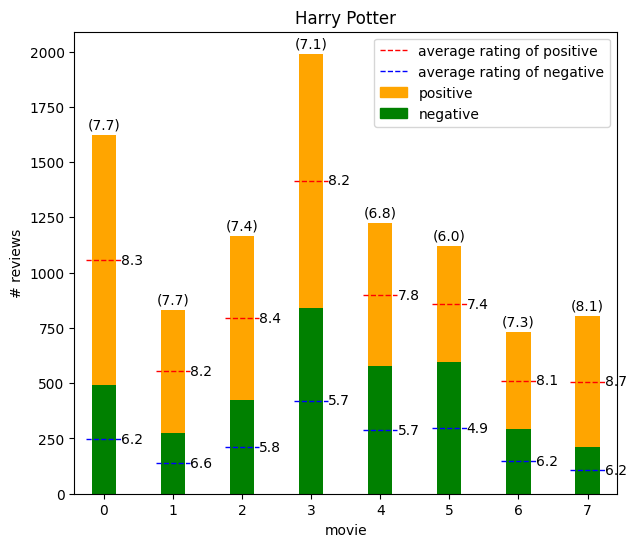

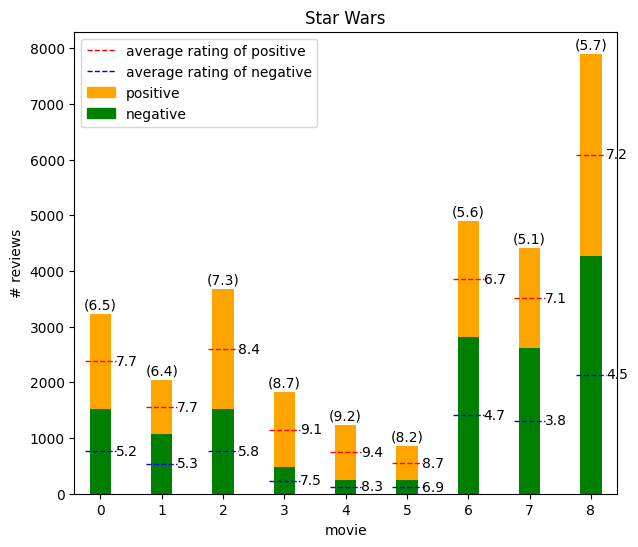

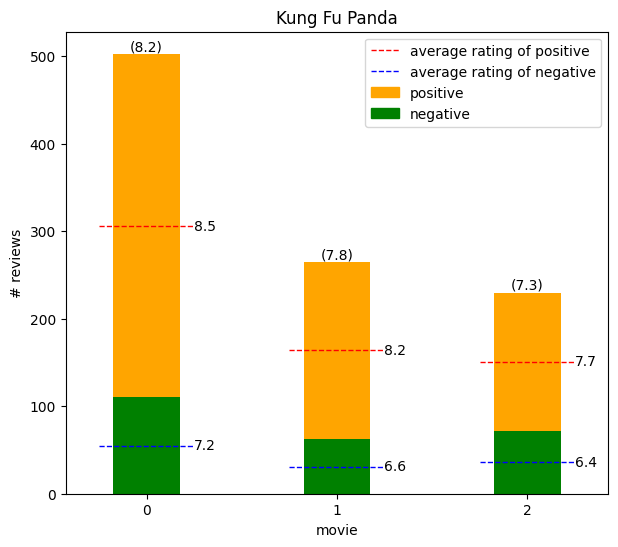

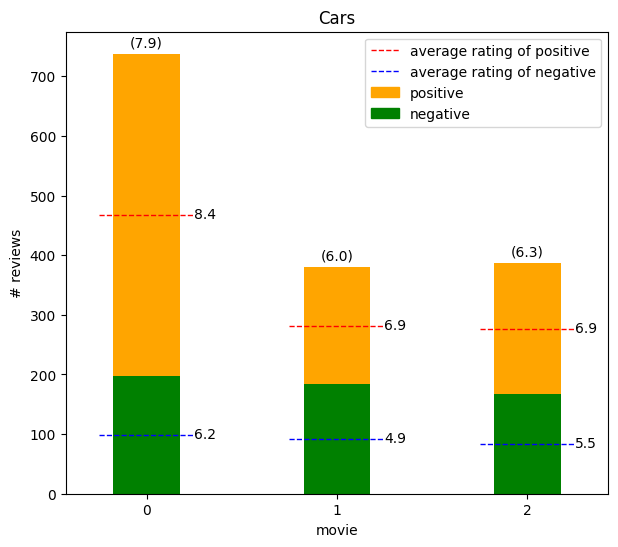

In [5]:
def get_dist(csv_path):
    # retrieve data
    df = pd.read_csv(csv_path)
    ratings = list(df['Rating'].values)
    sentiments = list(df['Sentiment'].values)
    # make lists
    rating_dist = [ratings.count(i) for i in range(1, 11)]
    sentiment_dist = [0 for _ in range(2)]
    sentiment_nan_dist = [0 for _ in range(2)]

    for i in range(df.shape[0]):
        r = ratings[i]
        s = sentiments[i]
        if math.isnan(r):
            sentiment_nan_dist[s] += 1
        else:
            sentiment_dist[s] += 1
    return np.array(rating_dist), np.array(sentiment_dist), np.array(sentiment_nan_dist)

def df_dist(series, num):
    r_list = []
    s_list = []
    s_nan_list = []
    for i in range(num):
        path = f'./reviews/annotated/{series}/{i}.csv'
        name = [str(i)]
        r, s, s_nan = get_dist(path)
        r_list.append([*name, *r])
        s_list.append([*name, *s])
        s_nan_list.append([*name, *s_nan])
    rating_df = pd.DataFrame(
        r_list,
        columns=['movie', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
    )
    sentiment_df = pd.DataFrame(
        s_list,
        columns=['movie', 'neg', 'pos']
    )
    sentiment_nan_df = pd.DataFrame(
        s_nan_list,
        columns=['movie', 'neg', 'pos']
    )
    return rating_df, sentiment_df, sentiment_nan_df

def get_average_ratings(series, num):
    average_rating_whole = []
    average_rating_pos = []
    average_rating_neg = []

    num_pos_review = []
    num_neg_review = []

    for i in range(num):
        path = f'./reviews/annotated/{series}/{i}.csv'
        df = pd.read_csv(path)
        sum_pos, cnt_pos, sum_neg, cnt_neg = 0, 0, 0, 0
        for j in range(df.shape[0]):
            r, s = list(df['Rating'].values)[j], list(df['Sentiment'].values)[j]
            if not math.isnan(r):
                if s == 0:
                    sum_neg += int(r)
                    cnt_neg += 1
                else:
                    sum_pos += int(r)
                    cnt_pos += 1
        # avg
        average_rating_whole.append((sum_pos+sum_neg)/(cnt_pos+cnt_neg))
        average_rating_pos.append(sum_pos/cnt_pos)
        average_rating_neg.append(sum_neg/cnt_neg)
        # num
        num_pos_review.append(sum_pos)
        num_neg_review.append(sum_neg)
    
    return average_rating_whole, (average_rating_pos, num_pos_review), (average_rating_neg, num_pos_review)

def plot_dist(dfs, title, num, avg_ratings):
    dfs[1].plot(x='movie', kind='bar', rot=0, stacked=True, figsize=(7, 6), position=0.5, width=0.35, color=['green','orange'], legend=False)
    plt.title(title)

    # width of each horizontal lines
    xmin = [i-0.25 for i in range(num)]
    xmax = [i+0.25 for i in range(num)]
    x = [i for i in range(num)]

    # y positions of the horizontal lines
    y = list(dfs[1]['neg'].values)
    whole_y = [i+j+(np.mean(y)/10) for i, j in zip(list(dfs[1]['neg'].values), list(dfs[1]['pos'].values))]
    neg_y = [i//2 for i in y]
    pos_y = [y[i] + list(dfs[1]['pos'].values)[i]//2 for i in range(len(list(dfs[1]['pos'].values)))]
    
    # entire average
    # plt.hlines(y=y, xmin=xmin, xmax=xmax, color='k', linestyle='dashed', lw=1)
    for i in range(num):
        plt.text(x[i], whole_y[i], f'({round(avg_ratings[0][i],1)})', ha ='center', va ='center')

    # positive average
    plt.hlines(y=pos_y, xmin=xmin, xmax=xmax, color='red', linestyle='dashed', lw=1)
    for i in range(num):
        plt.text(xmax[i], pos_y[i], round(avg_ratings[1][0][i],1), ha ='left', va ='center')

    # negative average
    plt.hlines(y=neg_y, xmin=xmin, xmax=xmax, color='blue', linestyle='dashed', lw=1)
    for i in range(num):
        plt.text(xmax[i], neg_y[i], round(avg_ratings[2][0][i], 1), ha ='left', va ='center')

    # config
    pos_patch = mpatches.Patch(color='orange', label='positive')
    neg_patch = mpatches.Patch(color='green', label='negative')
    plt.legend(
        handles=[
            Line2D([0], [0], color='red', linestyle='dashed', linewidth=1, label='average rating of positive'), 
            Line2D([0], [0], color='blue', linestyle='dashed', linewidth=1, label='average rating of negative'), 
            pos_patch, 
            neg_patch])
    plt.ylabel('# reviews')
    plt.show()

# plot
plot_dist(df_dist('harry_potter', 8), 'Harry Potter', 8, get_average_ratings('harry_potter', 8))
plot_dist(df_dist('star_wars', 9), 'Star Wars', 9, get_average_ratings('star_wars', 9))
plot_dist(df_dist('kung_fu_panda', 3), 'Kung Fu Panda', 3, get_average_ratings('kung_fu_panda', 3))
plot_dist(df_dist('cars', 3), 'Cars', 3, get_average_ratings('cars', 3))

#### 6.3 Sentiments for reviews without ratings

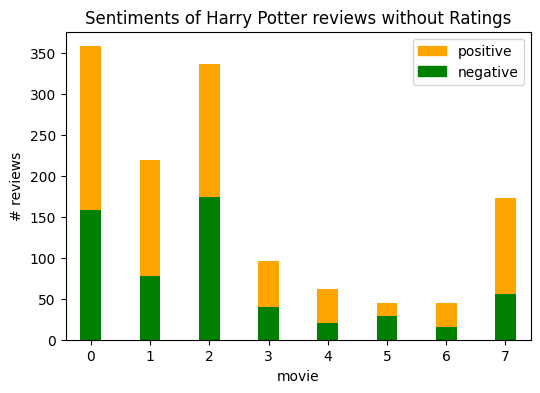

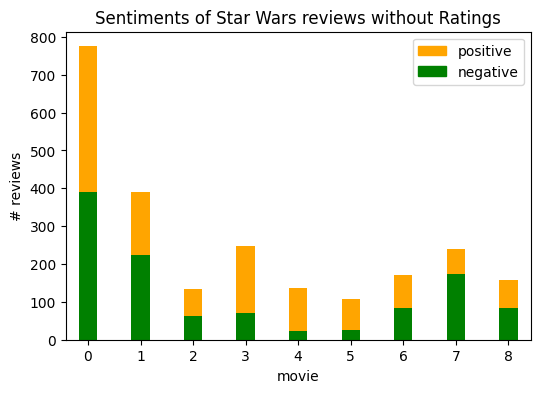

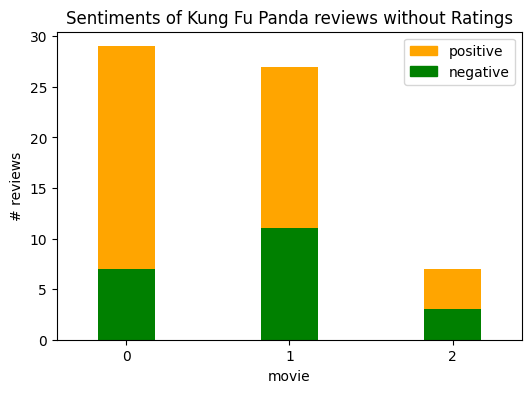

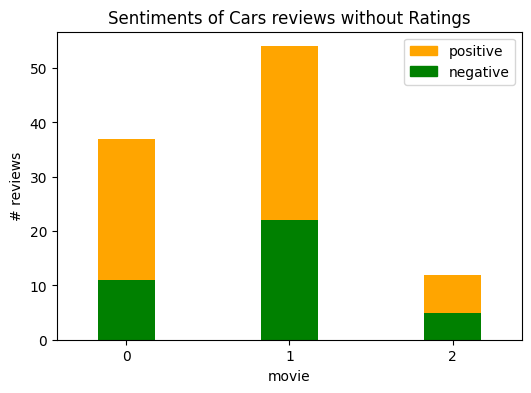

In [7]:
# get non-sentiment df's
_, _, hp_sentiment_nan_df = df_dist('harry_potter', 8)
_, _, sw_sentiment_nan_df = df_dist('star_wars', 9)
_, _, kp_sentiment_nan_df = df_dist('kung_fu_panda', 3)
_, _, cars_sentiment_nan_df = df_dist('cars', 3)

# plot
def plot_sentiment_on_nan_reviews(df, title):
    df.plot(x='movie', kind='bar', rot=0, stacked=True, figsize=(6, 4), position=0.5, width=0.35, color=['green','orange'], legend=False)
    plt.title(title)
    pos_patch = mpatches.Patch(color='orange', label='positive')
    neg_patch = mpatches.Patch(color='green', label='negative')
    plt.legend(handles=[pos_patch, neg_patch])
    plt.ylabel('# reviews')
    plt.show()

plot_sentiment_on_nan_reviews(hp_sentiment_nan_df, 'Sentiments of Harry Potter reviews without Ratings')
plot_sentiment_on_nan_reviews(sw_sentiment_nan_df, 'Sentiments of Star Wars reviews without Ratings')
plot_sentiment_on_nan_reviews(kp_sentiment_nan_df, 'Sentiments of Kung Fu Panda reviews without Ratings')
plot_sentiment_on_nan_reviews(cars_sentiment_nan_df, 'Sentiments of Cars reviews without Ratings')

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Examine Sentiments Part 2</p> 

#### 7. Define heuristic $h$ that can quantifies the popularity of movies.

#### 7.1 Distribution of star ratings of positive and negative reviews

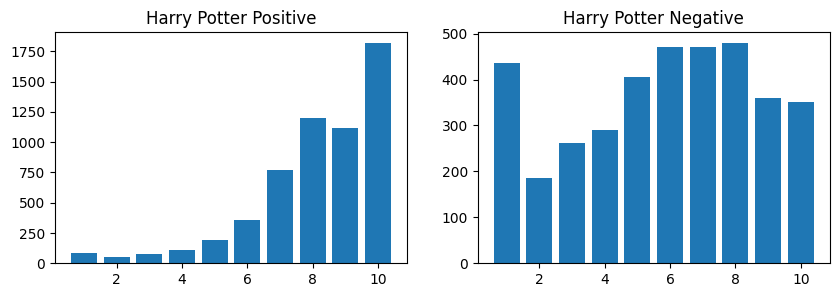

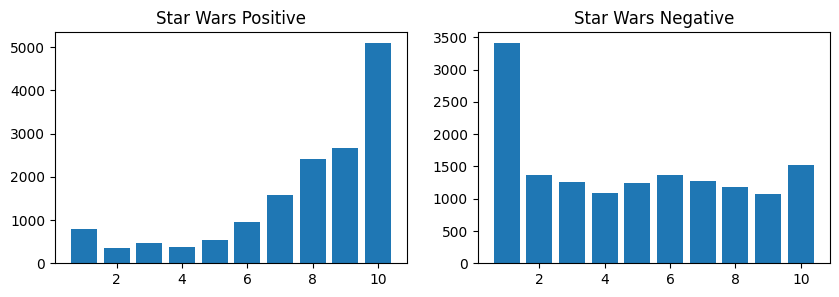

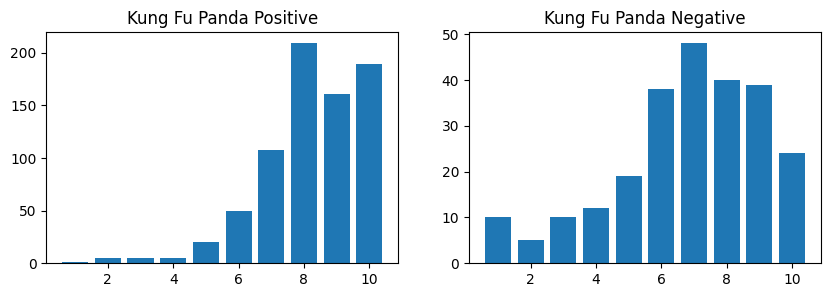

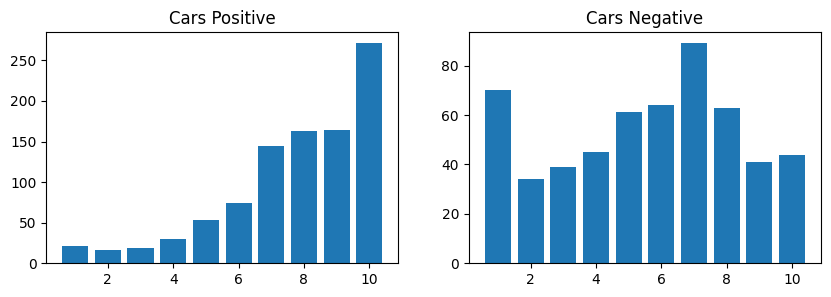

In [17]:
def get_ratings_dist(series, num):
    pos_dist = [0 for _ in range(10)]
    neg_dist = [0 for _ in range(10)]

    for i in range(num):
        path = f'./reviews/annotated/{series}/{i}.csv'
        df = pd.read_csv(path)
        for j in range(df.shape[0]):
            r, s = list(df['Rating'].values)[j], list(df['Sentiment'].values)[j]
            if not math.isnan(r):
                if s == 0:
                    neg_dist[int(r)-1] += 1
                else:
                    pos_dist[int(r)-1] += 1
    
    return pos_dist, neg_dist

def plot_dist(pos_dist, neg_dist, title):
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.bar([i for i in range(1,11)], pos_dist)
    plt.title(f'{title} Positive')
    plt.subplot(1,2,2)
    plt.bar([i for i in range(1,11)], neg_dist)
    plt.title(f'{title} Negative')


hp_pos_dist, hp_neg_dist = get_ratings_dist('harry_potter', 8)
plot_dist(hp_pos_dist, hp_neg_dist, 'Harry Potter')
sw_pos_dist, sw_neg_dist = get_ratings_dist('star_wars', 9)
plot_dist(sw_pos_dist, sw_neg_dist, 'Star Wars')
kp_pos_dist, kp_neg_dist = get_ratings_dist('kung_fu_panda', 3)
plot_dist(kp_pos_dist, kp_neg_dist, 'Kung Fu Panda')
cars_pos_dist, cars_neg_dist = get_ratings_dist('cars', 3)
plot_dist(cars_pos_dist, cars_neg_dist, 'Cars')

#### 7.2 Examples of reviews classified wrong

In [23]:
def get_bad_samples(series):
    pos_with_1 = []
    neg_with_10 = []

    path = f'./reviews/annotated/{series}/0.csv'
    df = pd.read_csv(path)
    
    for j in range(df.shape[0]):
        r, s, t = list(df['Rating'].values)[j], list(df['Sentiment'].values)[j], list(df['Review'].values)[j]
        if not math.isnan(r):
            if s == 0 and int(r) == 10:
                neg_with_10.append(t)
            elif s == 1 and int(r) == 1:
                pos_with_1.append(t)
    
    return pos_with_1, neg_with_10

pos_with_1, neg_with_10 = get_bad_samples('harry_potter')
print('Positive Review with 1 star: \n\n', pos_with_1[0])
print('\nNegative Review with 10 star: \n\n', neg_with_10[0])

Positive Review with 1 star: 

 My sister, bless her heart, used to work in a bookstore, and brought the novel this turkey is based upon home one day. After everyone else in my family had read it, I decided to give it a go because I had little better to do at the time. I wound up throwing the book across the room in around thirty pages, feeling that not only had my intelligence been insulted, so too had the already-persecuted-enough faiths of Wicca and its pagan relatives.

Negative Review with 10 star: 

 When I first saw this movie I was ten years old, the same age the characters where supposed to be. My older cousin and her boyfriend took me to the Mall to watch a movie. Back then I wasn't going very often to the cinema, due to the fact that my parents didn't have time and I wasn't old enough to go alone to any theater. The movie captivated my attention like nothing before and I became so interested in anything that had to do with this movie, and I heard that it was made after a boo

#### 7.3. Word Clouds (Positive and Negative)

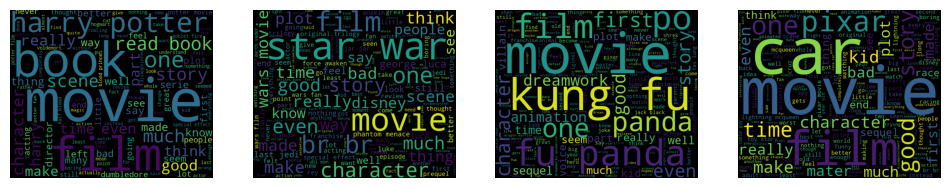

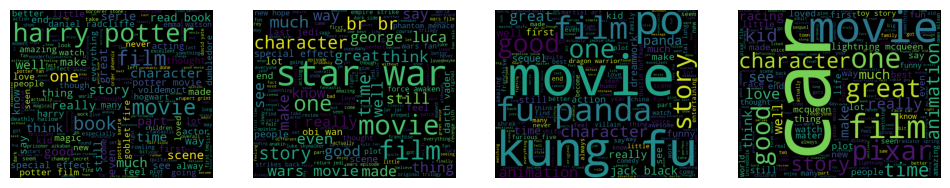

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import data

# go through all csv files and fill the strings
def get_text(series, num):
    pos_text = ''
    neg_text = ''
    for i in range(num):
        path = f'./reviews/annotated/{series}/{i}.csv'
        df = pd.read_csv(path)
        for j in range(df.shape[0]):
            s, r = list(df['Sentiment'].values)[j], list(df['Review'].values)[j]
            if s == 0:
                neg_text += r
            else:
                pos_text += r
    
    # remove stopwords and other extrenous words and return
    return data.parse_text(neg_text), data.parse_text(pos_text)

# get texts
hp_neg_text, hp_pos_text = get_text('harry_potter', 8)
sw_neg_text, sw_pos_text = get_text('star_wars', 9)
kp_neg_text, kp_pos_text = get_text('kung_fu_panda', 3)
cars_neg_text, cars_pos_text = get_text('cars', 3)

# visualize
def generate_wordcloud(hp_text, sw_text, kp_text, cars_text):
    hp_wordcloud = WordCloud(width = 600, height = 500, min_font_size = 10).generate(hp_text)
    sw_wordcloud = WordCloud(width = 600, height = 500, min_font_size = 10).generate(sw_text)
    kp_wordcloud = WordCloud(width = 600, height = 500, min_font_size = 10).generate(kp_text)
    cars_wordcloud = WordCloud(width = 600, height = 500, min_font_size = 10).generate(cars_text)

    plt.figure(figsize=(12, 3))
    plt.tight_layout(pad = 0)

    plt.subplot(1,4,1)
    plt.axis("off") 
    plt.imshow(hp_wordcloud) 

    plt.subplot(1,4,2)
    plt.axis("off") 
    plt.imshow(sw_wordcloud) 

    plt.subplot(1,4,3)
    plt.axis("off") 
    plt.imshow(kp_wordcloud) 

    plt.subplot(1,4,4)
    plt.axis("off") 
    plt.imshow(cars_wordcloud) 
    plt.show() 

generate_wordcloud(hp_neg_text, sw_neg_text, kp_neg_text, cars_neg_text)
generate_wordcloud(hp_pos_text, sw_pos_text, kp_pos_text, cars_pos_text)


The resulting word clouds actually resemble the wordcloud of the training datasets (shown below). Hence, we can say that our model learns the distribution of the training datasets very well. However, the actual content in these wordclouds remains unsatisfactory. 

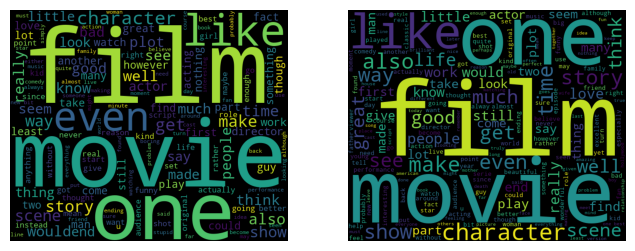

In [22]:
# get text
train_path = './train_data/train.csv'
train_df = pd.read_csv(train_path)
train_pos_text, train_neg_text = '', ''

for j in range(train_df.shape[0]):
    s, r = list(train_df['sentiment'].values)[j], list(train_df['text'].values)[j]
    if s == 'neg':
        train_neg_text += r
    else:
        train_pos_text += r

# parse text
train_neg_text, train_pos_text = data.parse_text(train_neg_text), data.parse_text(train_pos_text)

# plot
train_neg_wordcloud = WordCloud(width = 600, height = 500, stopwords=['br'], min_font_size = 10).generate(train_neg_text)
train_pos_wordcloud = WordCloud(width = 600, height = 500, stopwords=['br'], min_font_size = 10).generate(train_pos_text)

plt.figure(figsize=(8, 3))
plt.tight_layout(pad = 0)

plt.subplot(1,2,1)
plt.axis("off") 
plt.imshow(train_neg_wordcloud) 

plt.subplot(1,2,2)
plt.axis("off") 
plt.imshow(train_pos_wordcloud) 
plt.show() 

#### 7.4. Reason $h$

By feeding user reviews to our LSTM model, we have obtained the sentiments of these reviews in addition to star ratings. These sentiments can help us define a better heuristic of the popularity of a movie than the mere average rating because, as we see in the previous section, the star ratings are **subjective**, whereas people's sentiments are **absolute**. In other words, due to prior expection people have or other external factors, the star ratings cannot provide absolute measurement of how satsified people are with a particular movie. For instance, suppose we have two movies, Movie 1 and Movie 2. Say people expected Movie 1 to be very good because of all the ads they've watched (yielding higher average rating for both positive and negative reviews), while their expections for Movie 2 was not so much in comparison (yielding lower average rating for both positive and negative reviews). In this situation, the average of 8 star rating for Movie 1 does not necessarily indicates the same satisfication level as the average 8 star rating for Movie 2, rather people are less happy about Movie 1 than Movie 2 because of the high expectation. Hence, incorporating the average star ratings for positive/negative reviews, we can define the following heuristic $h$: $$h = a_p \cdot r_p - (10 - a_n) \cdot r_n$$ where $a_p$ and $a_n$ are the average rating of all the positive/negative reviews respectively, and $r_{p}$ and $r_{n}$ is the number of positive and negative reviews respectively. We choose not to normalize $h$ by the number of reviews remains questionable, because how many people are learving reviews on a particular movie can be another indication of the movie's popularity. However, as we see in 7.1, our model does not accurately classify negative sentiments. We thus modify our $h$ in such a way that all negative reviews are treated equal: $$h = a_p \cdot r_p - 1 \cdot r_n.$$

#### 7.5 Obtain and plot $h$ for the four series

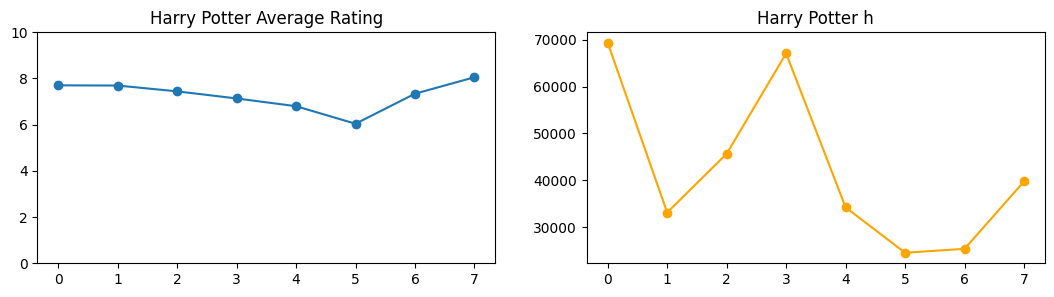

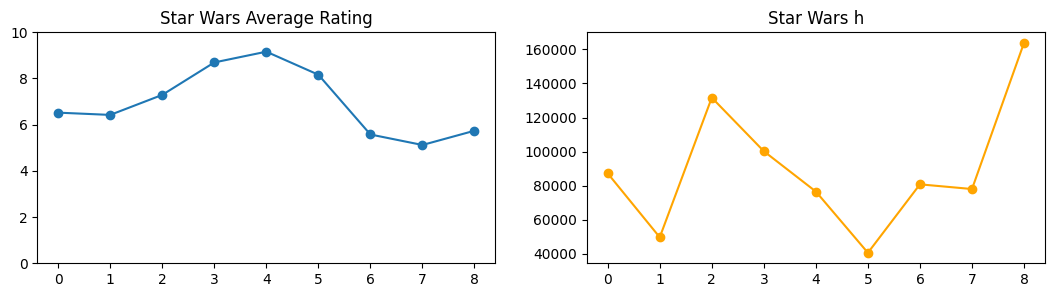

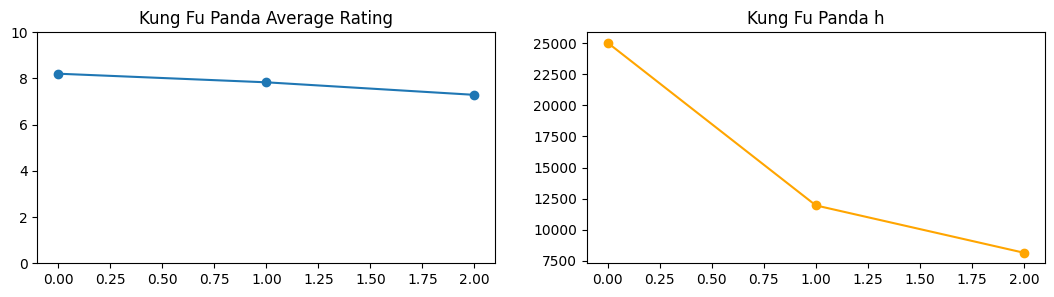

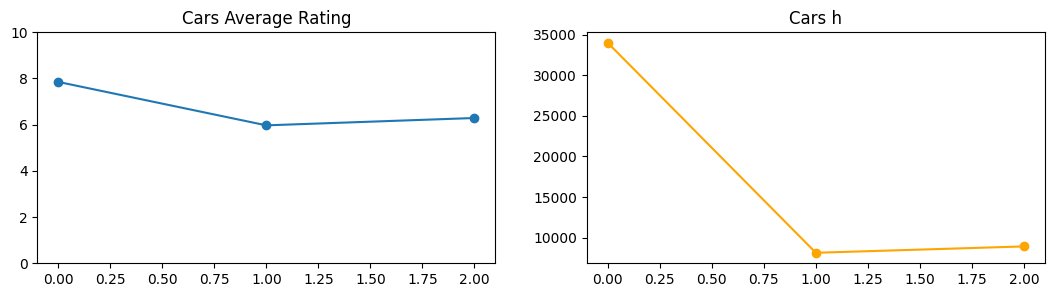

In [15]:
def compute_h(series, num):
    hp_avg, (hp_pos_avg, hp_num_pos), (hp_neg_avg, hp_num_neg) = get_average_ratings(series, num)
    h_list = []
    for i in range(num):
        h = hp_pos_avg[i] * hp_num_pos[i] - 1 * hp_num_neg[i]
        h_list.append(round(h))
    return [round(i, 3) for i in hp_avg], h_list

def plot_h(avg, sum_h, title):
    x = [i for i in range(len(avg))]

    plt.figure(figsize=(13, 3))

    plt.subplot(1, 2, 1)
    plt.plot(x, avg, marker='o')
    plt.title(f'{title} Average Rating')
    plt.ylim([0, 10])

    plt.subplot(1, 2, 2)
    plt.plot(x, sum_h, marker='o', color='orange')
    plt.title(f'{title} h')

hp_avg, hp_h = compute_h('harry_potter', 8) 
plot_h(hp_avg, hp_h, 'Harry Potter')
sw_avg, sw_h = compute_h('star_wars', 9) 
plot_h(sw_avg, sw_h, 'Star Wars')
kp_avg, kp_h = compute_h('kung_fu_panda', 3) 
plot_h(kp_avg, kp_h, 'Kung Fu Panda')
cars_avg, cars_h = compute_h('cars', 3) 
plot_h(cars_avg, cars_h, 'Cars')

# <p style ="padding: 10px; background-color: #192841; color : #F8F8FF; font-family: newtimeroman; font-size: 80%; text-align: center; border-radius : 15px 15px;"> Summary and Future Work</p> 

#### 8.1. Summary
You can find the analysis of these plots and more detailed docmentations in our blog post, however, we are able to implmenet and train a Bidirectional LSTM model that classifies movie reviews with high accuracy and use the results to make interesting conjectures about sequals and movies! 

#### 8.2. Future Work
Our future work can explore more complicated NLP models, such as transformers, and understand how these models can classify negative sentiments more accurately. About sequals, it would be interesting to try defining more precise heuristic $h$ and use it to build on the results we get in this porject!